# Forecast a multivariate time series : Stock Market Price 

## 0. Program Setting

In [1]:
import numpy as np
print(np.__version__)

1.18.1


In [2]:
import pandas as pd
print(pd.__version__)

1.0.1


In [3]:
import tensorflow as tf
tf.random.set_seed(1234)
print(tf.__version__)

2.1.0


## 1. Data Loading and Setting

**1-1 신한 TR에서 불러올 정보 셋팅**

In [4]:
code = '005930'          
tr_name = 'TR_SCHART'
term = '1'
start_date = '20190101'   
end_date = '20200312'
Lookup = '9999' 

**1-2 TR json 파일을 데이터프레임으로 변환**

In [5]:
url = 'http://ssecd.roboadvisor.co.kr:9999/' + tr_name + '?0=' + code + '&1=' + term + '&2=10' +\
      '&3=' + start_date + '&4=' + end_date + '&5=' + Lookup

In [6]:
from urllib.request import urlopen
url_page = urlopen(url)

In [7]:
import json
url_data = json.loads(url_page.read())

In [8]:
import pandas as pd
data = pd.DataFrame(url_data)

**1-3 데이터프레임의 칼럼명과 데이터 순서 등을 지정**

In [9]:
data.columns = ['date','time','open','high','low','close','price_ccr','volume_ccr','rock','volume','volume_price']
data = data[['date', 'time', 'open', 'high', 'low', 'close', 'volume', 'volume_price']]
data = data[::-1]
data['date_time'] = data['date'] + data['time']
data = data.set_index('date_time')
data = data[['open', 'high', 'low', 'close', 'volume', 'volume_price']]

**1-4 데이터 속성을 모두 정수로 변경**

In [10]:
for column in data.columns : 
    data[column] = data[column].apply(lambda x : int(x))

**1-5 데이터 결과**

In [11]:
data

,open,high,low,close,volume,volume_price
date_time,,,,,,
201912160910,54500,54800,54300,54800,889865,48520322900
201912160920,54700,54900,54600,54800,489897,26824806400
201912160930,54700,54900,54700,54700,306747,16808556000
201912160940,54700,54800,54600,54600,246671,13487653400
201912160950,54600,54700,54500,54600,331158,18075227400
...,...,...,...,...,...,...
202003121450,51000,51200,50500,50600,851501,43230555800
202003121500,50500,50900,50400,50500,803526,40674912000
202003121510,50600,50600,50100,50200,884130,44492667000


In [12]:
data.describe()

,open,high,low,close,volume,volume_price
count,2298.000000,2298.000000,2298.000000,2298.000000,2.298000e+03,2.298000e+03
mean,57799.825936,57905.308964,57678.154917,57803.089643,4.600753e+05,2.632608e+10
std,2561.143877,2553.034783,2571.733455,2563.679457,5.277573e+05,2.960559e+10
min,49750.000000,49900.000000,49300.000000,49750.000000,0.000000e+00,0.000000e+00
25%,55900.000000,56000.000000,55800.000000,55900.000000,1.794420e+05,1.044364e+10
50%,57400.000000,57500.000000,57300.000000,57400.000000,3.347300e+05,1.943569e+10
75%,60000.000000,60000.000000,59900.000000,60000.000000,5.466562e+05,3.143708e+10
max,62700.000000,62800.000000,62600.000000,62800.000000,7.771531e+06,4.554117e+11


## 2. Univariate Model

**2.1 종가 데이터만 가져오기**

In [13]:
uni_data = data['close']
uni_data

date_time
201912160910    54800
201912160920    54800
201912160930    54700
201912160940    54600
201912160950    54600
                ...  
202003121450    50600
202003121500    50500
202003121510    50200
202003121520    50500
202003121530    50800
Name: close, Length: 2298, dtype: int64

**2.2 종가 시계열 그래프**

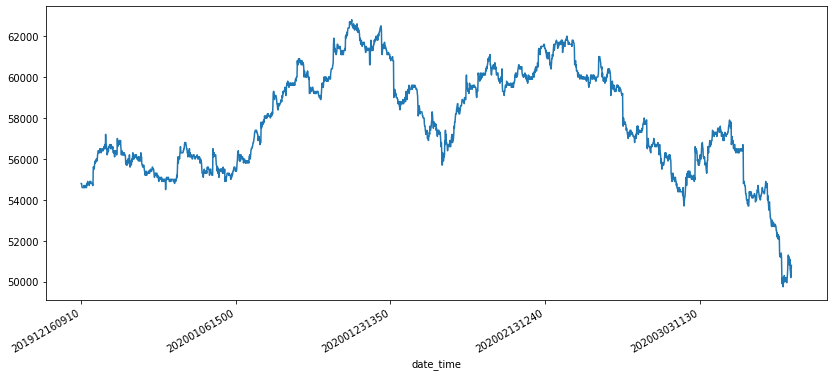

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,6)
uni_data.plot(subplots=True)
plt.show()

**2.3 종가 데이터 값만 추출**

In [15]:
uni_data = uni_data.values

**2.4 데이터 정규화**

In [16]:
TRAIN_SPLIT = 2000

In [17]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [18]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

**2.5 일변량 모델을 위한 데이터**

In [19]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
            
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [20]:
# 과거 20일치의 데이터를 사용
univariate_past_history = 20

In [21]:
# 바로 다음 스텝을 예측
univariate_future_target = 0

In [22]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

In [23]:
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

**2.6 데이터 구조**

In [24]:
x_train_uni.shape, y_train_uni.shape, x_val_uni.shape, y_val_uni.shape, 

((1980, 20, 1), (1980,), (278, 20, 1), (278,))

**2.7 전처리된 데이터셋 결과**

In [25]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.50138178]
 [-1.50138178]
 [-1.54492787]
 [-1.58847395]
 [-1.58847395]
 [-1.58847395]
 [-1.58847395]
 [-1.58847395]
 [-1.58847395]
 [-1.54492787]
 [-1.58847395]
 [-1.58847395]
 [-1.54492787]
 [-1.58847395]
 [-1.54492787]
 [-1.54492787]
 [-1.58847395]
 [-1.58847395]
 [-1.50138178]
 [-1.54492787]]

 Target temperature to predict
-1.5013817840994153


**2.7 사용되는 데이터와 예측 타겟 시각화**

In [26]:
def create_time_steps(length):
    return list(range(-length, 0))

In [27]:
def show_plot(plot_data, delta, title) :
    
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    
    return plt

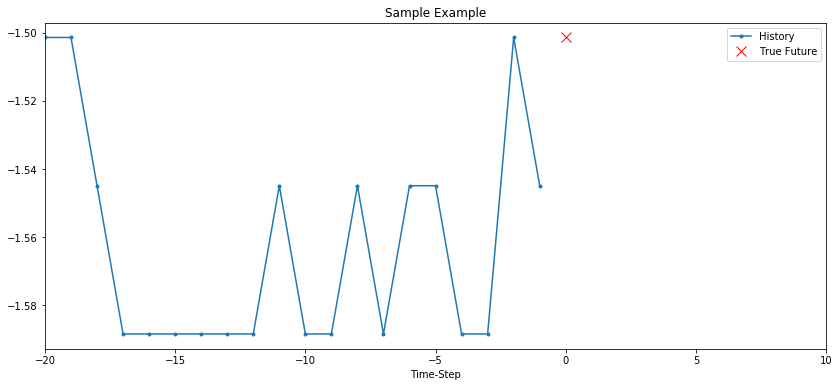

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,6)
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plt.show()

**2.8 Baseline(모델의 기준이되는 값)**

In [29]:
def baseline(history) : 
    return np.mean(history)

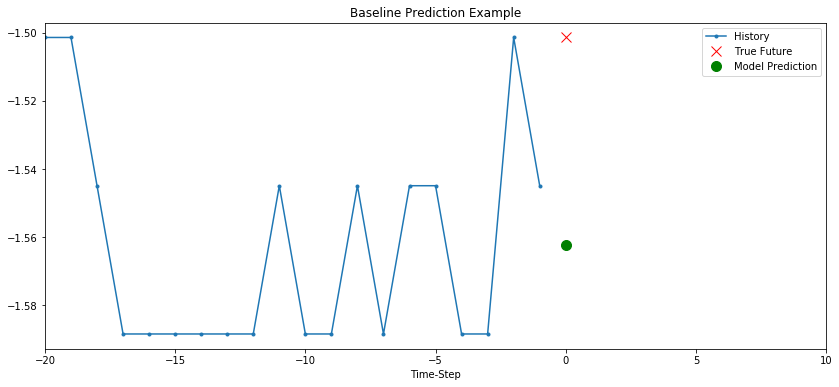

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,6)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')
plt.show()

**2.9 LSTM (Long Short Term Memory)을 위한 데이터셋**

RNN (Recurrent Neural Network)은 시계열 데이터에 적합한 신경 네트워크 유형입니다. RNN은 시계열을 단계별로 처리하여 지금까지 본 정보를 요약하여 내부 상태를 유지합니다. 자세한 내용은 RNN 튜토리얼을 참조하십시오. 이 자습서에서는 LSTM (Long Short Term Memory)이라는 특수 RNN 계층을 사용합니다.

이제 tf.data를 사용하여 데이터 세트를 셔플, 배치 및 캐시 해 봅시다.

In [31]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [32]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [33]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [34]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(32, 1)


In [35]:
EVALUATION_INTERVAL = 200
EPOCHS = 20

In [36]:
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 5s 23ms/step - loss: 0.3510 - val_loss: 0.5571
Epoch 2/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0963 - val_loss: 0.3935
Epoch 3/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0809 - val_loss: 0.3162
Epoch 4/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0704 - val_loss: 0.2975
Epoch 5/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0655 - val_loss: 0.2623
Epoch 6/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0612 - val_loss: 0.2388
Epoch 7/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0595 - val_loss: 0.2243
Epoch 8/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0567 - val_loss: 0.2090
Epoch 9/20
200/200 [==============================] - 3s 14ms/step - loss: 0.0562 - val_loss: 0.2027
Epoch 10/20
200/200 [===========================

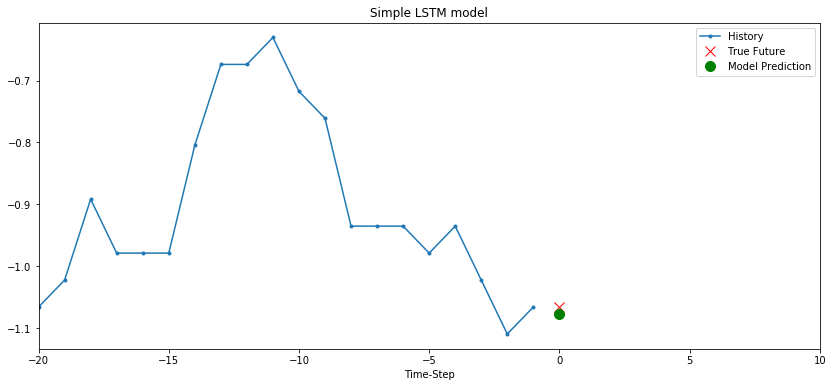

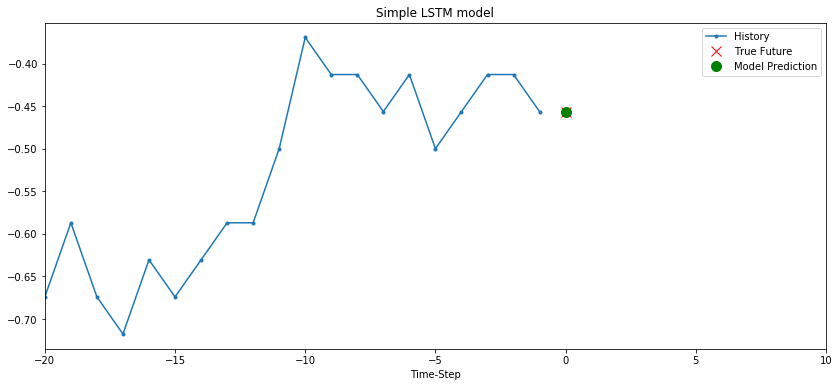

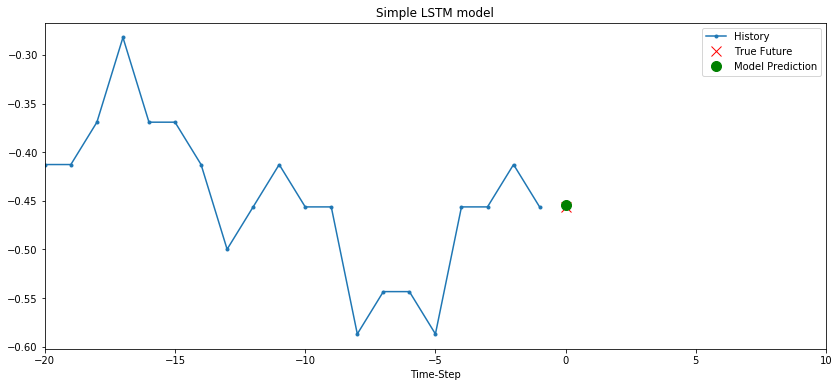

In [37]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()